In [1]:
library(DBI)
library(RMySQL)
mydb = dbConnect(MySQL(), user='remuser', password='rempwd', dbname='yelp_db', host='ec2-34-216-35-252.us-west-2.compute.amazonaws.com', port=3306)

In [2]:
# Create volume variable based on the checkin data 
checkin = dbGetQuery(mydb, "select business_id, sum(count) from checkin group by business_id")

Warning message in .local(conn, statement, ...):
“Decimal MySQL column 1 imported as numeric”

In [3]:
head(checkin)

business_id,sum(count)
--6MefnULPED_I942VcFNA,122
--7zmmkVg-IMGaXbuVd0SQ,132
--8LPVSo5i0Oo61X01sV9A,1
--9e1ONYQuAa-CB_Rrw7Tw,2469
--9QQLMTbFzLJ_oT-ON3Xw,29
--ab39IjZR_xUf81WyTyHg,61


In [4]:
# Take a look at the category table 
category=dbGetQuery(mydb,"select * from category")

In [5]:
# See if the industry will effect the volume or not.
# Here, we list some common categories used for food service, but there are more. 
category$food=0
category$food[category$category%in% c("Restaurants","Food","Bars","Chinese","Sushi Bar","Coffee & Tea","Sandwiches","Burgers","Bakeries"," Breakfast & Brunch",
                                      "Mexican","Seafood","American (Traditional)","Pizza","Italian","Soul food")]=1

In [6]:
summary(category)

 business_id          category              food       
 Length:590290      Length:590290      Min.   :0.0000  
 Class :character   Class :character   1st Qu.:0.0000  
 Mode  :character   Mode  :character   Median :0.0000  
                                       Mean   :0.2179  
                                       3rd Qu.:0.0000  
                                       Max.   :1.0000  

In [7]:
# Merge two data frames
checkin$food[checkin$business_id%in% category$business_id]=category$food 
checkin$food[is.na(checkin$food)]= 0

Warning message in checkin$food[checkin$business_id %in% category$business_id] = category$food:
“number of items to replace is not a multiple of replacement length”

In [8]:
head(checkin)

business_id,sum(count),food
--6MefnULPED_I942VcFNA,122,0
--7zmmkVg-IMGaXbuVd0SQ,132,0
--8LPVSo5i0Oo61X01sV9A,1,1
--9e1ONYQuAa-CB_Rrw7Tw,2469,0
--9QQLMTbFzLJ_oT-ON3Xw,29,0
--ab39IjZR_xUf81WyTyHg,61,1


In [9]:
# Extract rating data from business table.
rating=dbGetQuery(mydb, "select id, neighborhood, city, state, postal_code, review_count,stars from business")
checkin=merge(x=checkin,y=rating,by.x="business_id",by.y="id",all.x=TRUE)

In [10]:
# Create neighborhood variable. Since it is a string variable, and have many levels, we decidied to seperate business
# with and without neighborhood.
names(checkin)[2] = "volume"
checkin$neb[checkin$neighborhood==""] <- 0
checkin$neb[is.na(checkin$neb)]<- 1

# Create photo number and tip number variable provided by users
photo=dbGetQuery(mydb,'select business_id, count(1) from photo group by business_id')
names(photo)[2]='photo'
tips=dbGetQuery(mydb,'select business_id, count(1) from tip group by business_id')
names(tips)[2]='tip'
checkin$photo=0
checkin$photo[checkin$business_id%in%photo$business_id]=photo$photo
checkin$tips=0
checkin$tips[checkin$business_id%in%tips$business_id]=tips$tip

# Generate region variable by region, also utilize the data in the package about Population, 
#Income,Illiteracy,etc.
states=data.frame(state = state.abb,region = state.region,
state.x77,row.names = 1:50)
checkin=merge(x=checkin,y=states,by='state',all.x= TRUE)

# Create variables according to attribute table
# The number indicate the business's price range 
pr=dbGetQuery(mydb,'select * from attribute where name="RestaurantsPriceRange2"')
pr$value=as.numeric(pr$value)

# The number represent its attitude to kids
checkin$pricerange[checkin$business_id%in%pr$business_id]=pr$value
gfk=dbGetQuery(mydb,'select * from attribute where name="GoodForKids"')
gfk$value=as.numeric(gfk$value)
checkin$goodforkid[checkin$business_id%in%gfk$business_id]=gfk$value

# Let alcohol be "1" if it is allowed, else 0
al=dbGetQuery(mydb,'select * from attribute where name="Alcohol"')
al$values=0
al$values[al$value=="full_bar"]=1
checkin$alcohol[checkin$business_id%in%al$business_id]=al$values

# "1" indicate can only by appointment 
bao=dbGetQuery(mydb,'select * from attribute where name="ByAppointmentOnly"')
bao$value=as.numeric(bao$value)
checkin$appointment[checkin$business_id%in%bao$business_id]=bao$value

head(checkin)

Warning message in checkin$photo[checkin$business_id %in% photo$business_id] = photo$photo:
“number of items to replace is not a multiple of replacement length”Warning message in checkin$tips[checkin$business_id %in% tips$business_id] = tips$tip:
“number of items to replace is not a multiple of replacement length”Warning message in checkin$pricerange[checkin$business_id %in% pr$business_id] = pr$value:
“number of items to replace is not a multiple of replacement length”Warning message in checkin$goodforkid[checkin$business_id %in% gfk$business_id] = gfk$value:
“number of items to replace is not a multiple of replacement length”Warning message in checkin$alcohol[checkin$business_id %in% al$business_id] = al$values:
“number of items to replace is not a multiple of replacement length”Warning message in checkin$appointment[checkin$business_id %in% bao$business_id] = bao$value:
“number of items to replace is not a multiple of replacement length”

state,business_id,volume,food,neighborhood,city,postal_code,review_count,stars,neb,⋯,Illiteracy,Life.Exp,Murder,HS.Grad,Frost,Area,pricerange,goodforkid,alcohol,appointment
01,JAyiN0OolvgdL2kliTNDnA,3,0,,Moss,1530,3,4.5,0,⋯,NA,NA,NA,NA,NA,NA,2,1,0,NA
01,7MrVKrTj_cULIAF8Z3_P-A,10,0,,Moss,1530,4,3.0,0,⋯,NA,NA,NA,NA,NA,NA,2,1,1,NA
01,39NX6v8cWKDnXIcVPFiFGQ,10,0,,Moss,1530,6,3.5,0,⋯,NA,NA,NA,NA,NA,NA,NA,1,0,NA
01,YCbeogQRRYREzuitTOjCIw,3,0,,Moss,1530,3,3.5,0,⋯,NA,NA,NA,NA,NA,NA,2,1,0,NA
01,GdYvxyIZetApni8u32DS9w,12,0,,Moss,1530,5,3.5,0,⋯,NA,NA,NA,NA,NA,NA,1,1,1,NA
01,t7IofjOiT0WRPonk7-jBJw,17,0,,Moss,1530,3,3.5,0,⋯,NA,NA,NA,NA,NA,NA,2,1,1,NA


In [11]:
summary(checkin)

    state           business_id            volume            food       
 Length:135148      Length:135148      Min.   :     1   Min.   :0.0000  
 Class :character   Class :character   1st Qu.:     5   1st Qu.:0.0000  
 Mode  :character   Mode  :character   Median :    18   Median :0.0000  
                                       Mean   :   117   Mean   :0.2183  
                                       3rd Qu.:    67   3rd Qu.:0.0000  
                                       Max.   :126689   Max.   :1.0000  
                                                                        
 neighborhood           city           postal_code         review_count    
 Length:135148      Length:135148      Length:135148      Min.   :   3.00  
 Class :character   Class :character   Class :character   1st Qu.:   5.00  
 Mode  :character   Mode  :character   Mode  :character   Median :  11.00  
                                                          Mean   :  34.08  
                                    

In [12]:
data<-data.frame(checkin$volume,checkin$stars,checkin$review_count,checkin$photo,checkin$tips)
cor(data)

,checkin.volume,checkin.stars,checkin.review_count,checkin.photo,checkin.tips
checkin.volume,1.000000000,0.007513261,0.64486079,0.052787166,0.01600536
checkin.stars,0.007513261,1.000000000,0.03585348,-0.006132428,-0.01428729
checkin.review_count,0.644860789,0.035853478,1.00000000,0.111018445,0.02781869
checkin.photo,0.052787166,-0.006132428,0.11101844,1.000000000,0.01336128
checkin.tips,0.016005356,-0.014287295,0.02781869,0.013361281,1.00000000


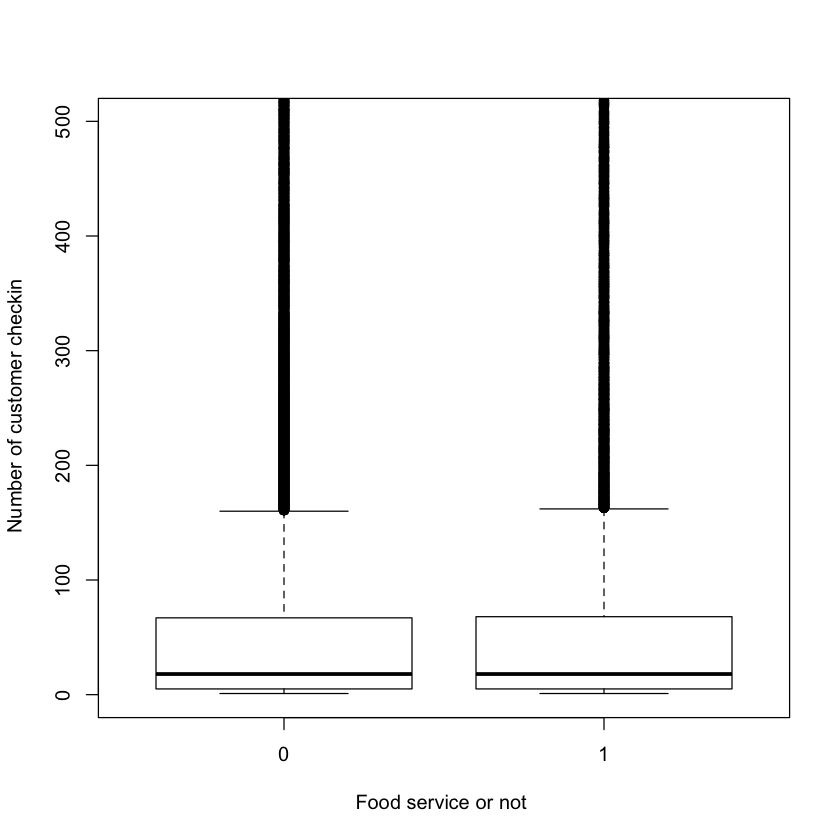

In [13]:
# The relationshio is not very obvious 
boxplot(checkin$volume ~ checkin$food, checkin ,ylab =" Number of customer checkin",xlab ="Food service or not ", ylim = c(0, 500))

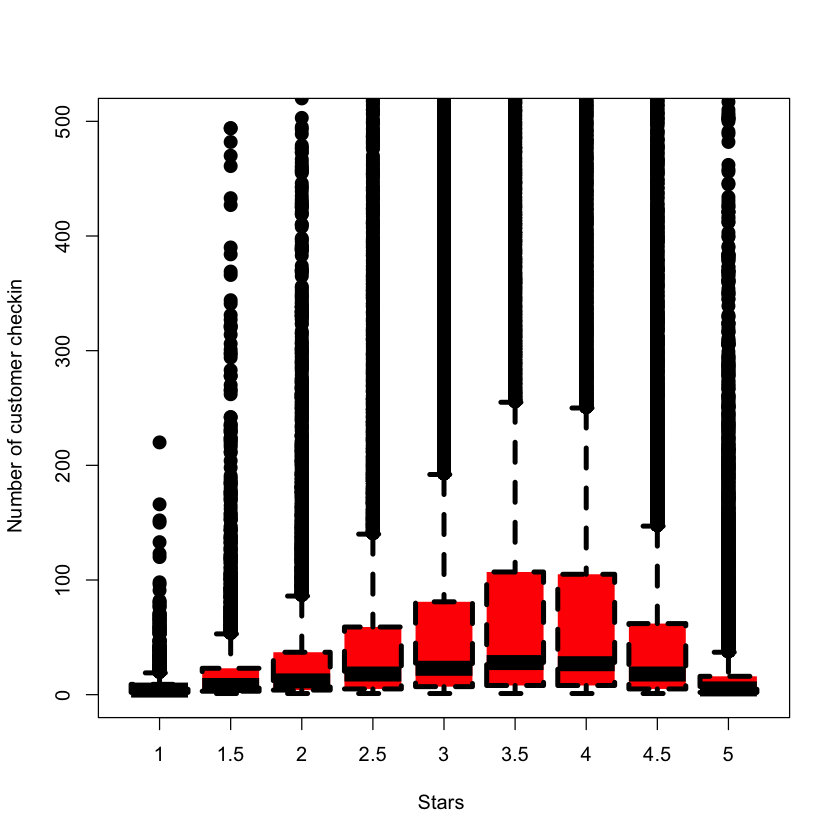

In [14]:
boxplot(checkin$volume ~ checkin$stars, checkin ,ylab =" Number of customer checkin",xlab ="Stars ", 
     ylim = c(0, 500),col='red',pch=19,bg='green',lwd=4,lty=2)


Warning message:
“Removed 225 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 225 rows containing missing values (geom_point).”

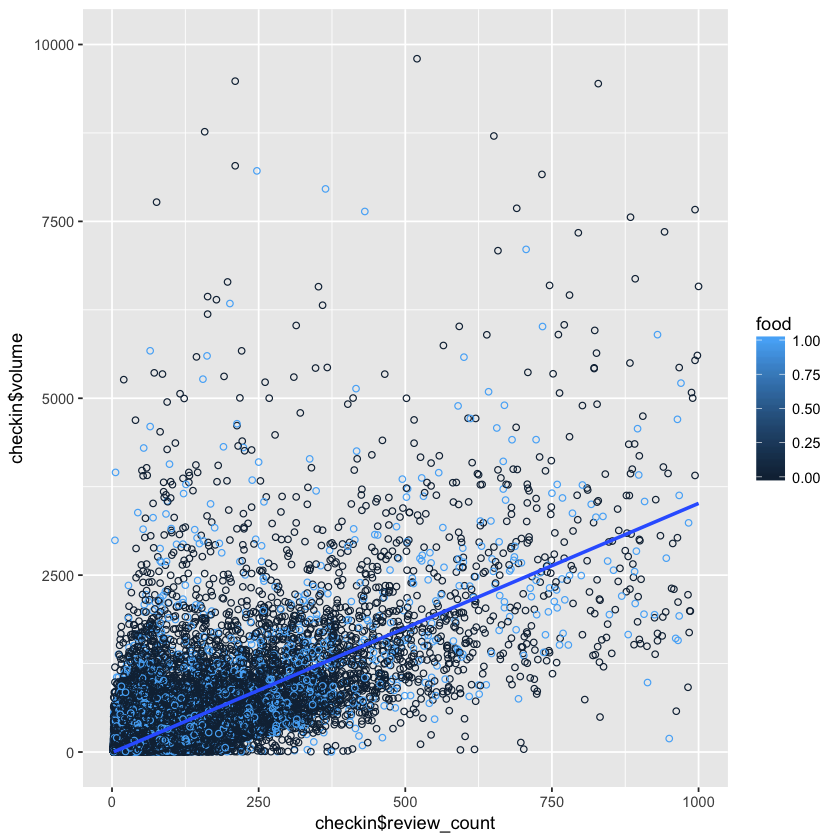

In [16]:
library(ggplot2)
#ggplot(checkin, aes(x = checkin$review_count, y = checkin$volume)) + geom_point() + facet_grid(~food)
ggplot(checkin, aes(x = checkin$review_count, y = checkin$volume, color=food)) + geom_point(shape=1) + geom_smooth(method=lm)+xlim(0,1000)+ylim(0,10000)

Warning message:
“Removed 143 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 143 rows containing missing values (geom_point).”

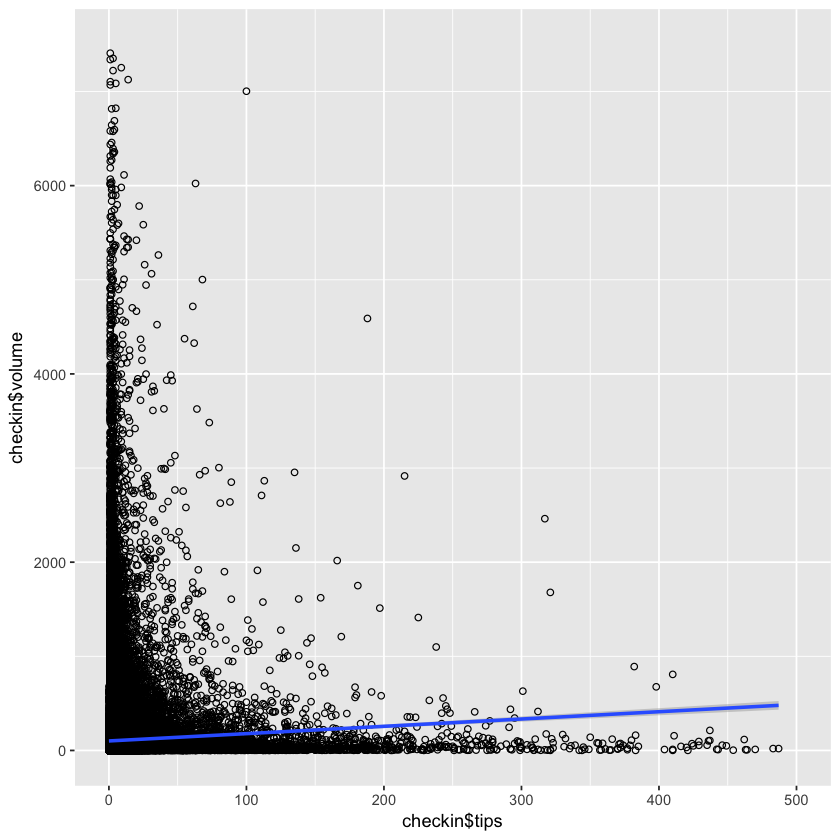

In [17]:
ggplot(checkin, aes(x = checkin$tips, y = checkin$volume)) + geom_point(shape=1) + geom_smooth(method=lm)+xlim(0,500)+ylim(0,7500)

Warning message:
“Removed 71 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 71 rows containing missing values (geom_point).”

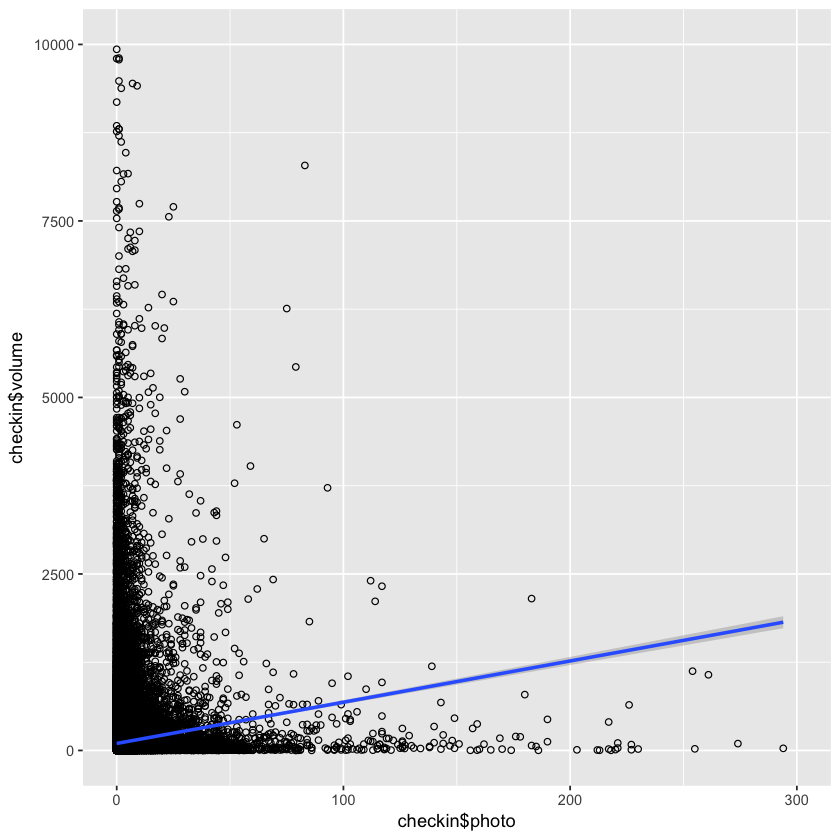

In [18]:
ggplot(checkin, aes(x = checkin$photo, y = checkin$volume)) + geom_point(shape=1) + geom_smooth(method=lm)+xlim(0,300)+ylim(0,10000)

In [32]:
reg=glm(volume~food+neb+stars+review_count+photo+tips,data=checkin,family='poisson')
summary(reg)


Call:
glm(formula = volume ~ food + neb + stars + review_count + photo + 
    tips, family = "poisson", data = checkin)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-832.51   -12.82   -10.51    -4.20   880.42  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  4.462e+00  1.106e-03 4032.94   <2e-16 ***
food         1.473e-02  6.055e-04   24.33   <2e-16 ***
neb          1.933e-01  5.217e-04  370.51   <2e-16 ***
stars        2.181e-02  2.857e-04   76.35   <2e-16 ***
review_count 1.176e-03  1.747e-07 6730.88   <2e-16 ***
photo        5.204e-03  6.241e-06  833.83   <2e-16 ***
tips         1.215e-03  3.154e-06  385.27   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 57277415  on 135147  degrees of freedom
Residual deviance: 43948189  on 135141  degrees of freedom
AIC: 44602163

Number of Fisher Scoring iterations: 8


In [33]:
exp(reg$coefficients) - 1

(Intercept)         food          neb        stars review_count        photo 
85.620266891  0.014839641  0.213260448  0.022049038  0.001176462  0.005217813 
        tips 
 0.001215805

In [34]:
reg=glm(volume~food+neb+stars+review_count+photo+tips+region+Population+Income,data=checkin,family='poisson')
summary(reg)


Call:
glm(formula = volume ~ food + neb + stars + review_count + photo + 
    tips + region + Population + Income, family = "poisson", 
    data = checkin)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-739.95   -14.22    -9.61    -3.01   871.14  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          3.561e+00  9.410e-03  378.42   <2e-16 ***
food                -1.911e-02  6.395e-04  -29.89   <2e-16 ***
neb                  5.033e-01  8.348e-04  602.94   <2e-16 ***
stars               -1.924e-02  2.871e-04  -67.01   <2e-16 ***
review_count         1.061e-03  1.876e-07 5654.15   <2e-16 ***
photo                1.195e-02  1.142e-05 1047.10   <2e-16 ***
tips                 2.446e-03  6.956e-06  351.64   <2e-16 ***
regionSouth          3.439e-01  3.268e-03  105.23   <2e-16 ***
regionNorth Central  4.730e-02  1.975e-03   23.95   <2e-16 ***
regionWest           1.045e+00  3.814e-03  274.01   <2e-16 ***
Population           

In [35]:
exp(reg$coefficients) - 1

(Intercept)                food                 neb               stars 
       3.419877e+01       -1.893149e-02        6.541807e-01       -1.905770e-02 
       review_count               photo                tips         regionSouth 
       1.061428e-03        1.202447e-02        2.449177e-03        4.104277e-01 
regionNorth Central          regionWest          Population              Income 
       4.843597e-02        1.843547e+00        1.269259e-05        5.760562e-05

In [36]:
reg=glm(volume~food+neb+stars+review_count+photo+tips+region+Population+Income+goodforkid+appointment+alcohol+pricerange,data=checkin,family='poisson')
summary(reg)


Call:
glm(formula = volume ~ food + neb + stars + review_count + photo + 
    tips + region + Population + Income + goodforkid + appointment + 
    alcohol + pricerange, family = "poisson", data = checkin)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-105.148   -23.519    -9.923     9.045   121.728  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          6.433e+00  7.600e-02  84.649  < 2e-16 ***
food                -1.415e-02  4.139e-03  -3.418 0.000631 ***
neb                  4.103e-01  7.074e-03  58.010  < 2e-16 ***
stars                3.071e-01  3.426e-03  89.659  < 2e-16 ***
review_count         9.871e-04  1.848e-06 534.246  < 2e-16 ***
photo                1.231e-02  9.481e-05 129.882  < 2e-16 ***
tips                 1.893e-03  7.797e-05  24.274  < 2e-16 ***
regionSouth         -1.586e-01  2.901e-02  -5.466 4.59e-08 ***
regionNorth Central  7.660e-01  1.969e-02  38.894  < 2e-16 ***
regionWest           1.9

In [37]:
exp(reg$coefficients) - 1

(Intercept)                food                 neb               stars 
       6.211948e+02       -1.404653e-02        5.073398e-01        3.595225e-01 
       review_count               photo                tips         regionSouth 
       9.875985e-04        1.239044e-02        1.894490e-03       -1.466525e-01 
regionNorth Central          regionWest          Population              Income 
       1.151082e+00        6.035321e+00        2.573188e-05       -6.245021e-04 
         goodforkid         appointment             alcohol          pricerange 
      -1.245539e-01       -1.155874e-01        8.560035e-02        3.863300e-02

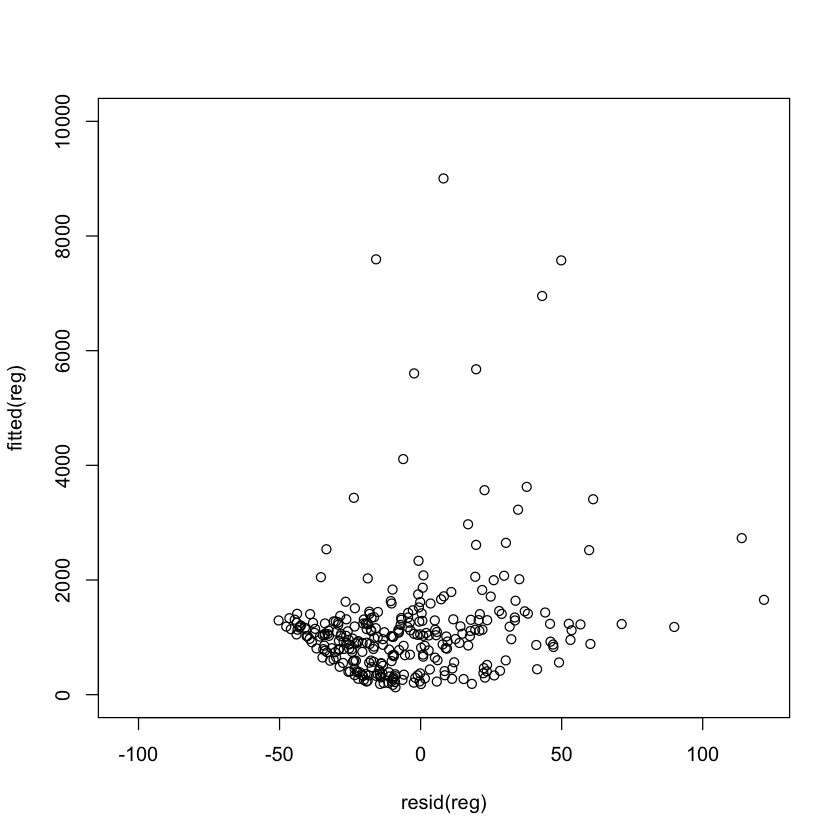

In [51]:
plot(resid(reg),fitted(reg),ylim=c(0,10000))